In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, PredictionErrorDisplay
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from textwrap import wrap

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model, get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf

import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [2]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
655,1,223.0,NaN,NaN,54.0,170.0,18.685121,113.0,75.0,0.0,67.0,0.0,79.0,0.848101,0.0,1.0,0.394118,0.0,0.0,1.0,NaN,NaN,NaN,1.0,0.0,NaN,NaN,1.0,4.763655,4.39722,9.160875,NaN,1.0,7.65,8.8900,16.5400,1.0,NaN,NaN,5.44,3.24,1.67,0.40,0.07,0.04,59.5,30.7,7.4,1.3,0.7,4.06,13.0,37.7,2.900000,92.9,32.0,34.5,12.1,0.0,249.0,13.6,11.1,33.8,45.772059,0.044578,149.101796,4.175000,1.940120,0.306985,0.012868,138.0,4.32,10.01,NaN,0.61,NaN,14.0,14.0,NaN,172.0,4.44792,0.0,91.0,2.35326,0.0,79.0,2.042940,0.0,NaN,NaN,NaN,0.868132,NaN,NaN,28.470588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.0,NaN,11.00,NaN,2.281481,NaN,0.337192,0.0,NaN,3.09,5.51,16.80,222.0,233.0,6.5,14.1,2.169231,670.0,345.0,1.01,0.291066,0.018133,164.910890,NaN,478.0,NaN,48.0,55.7,1.81,20.50,NaN,NaN,4.18,1.78,925.0,NaN,0.241627,NaN,NaN,NaN
887,3,453.0,NaN,NaN,60.0,170.0,20.761246,124.0,69.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,5.496525,2.41416,7.910685,NaN,NaN,2.04,1.5300,3.5700,0.0,0.0,0.0,5.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.24,14.3,44.7,3.125874,85.3,27.3,32.0,14.3,0.0,274.0,13.9,10.9,33.0,51.893939,0.039781,NaN,NaN,NaN,NaN,NaN,145.0,4.54,10.23,4.31,0.86,0.3,12.0,17.0,0.64,179.0,4.62894,0.0,71.0,1.83606,0.0,86.7,2.242062,0.0,109.0,1.23061,0.0,1.221127,1.535211,NaN,NaN,NaN,4.653234,0.186168,343.0,73.0,417.0,18.0,NaN,101.0,NaN,19.17,NaN,4.780667,NaN,0.304234,1.0,NaN,3.02,4.89,16.53,16.0,10.0,200.0,118.3,0.5915

### Handle `vitamine D ` outliers

In [3]:
df[VITAMINE_D].mean()

25.551785714285714

In [4]:
df[VITAMINE_D].std()

12.965793597129847

In [5]:
25.5+13+13+13

64.5

In [6]:
df[df[VITAMINE_D] > 64.5][VITAMINE_D]

92      66.0
219     89.0
542     66.0
831     73.0
872     82.0
975    129.0
Name: vitamin 25-OH D ng/ml, dtype: float64

In [7]:
df.loc[df[VITAMINE_D] > 64.5, VITAMINE_D] = np.nan

<Axes: >

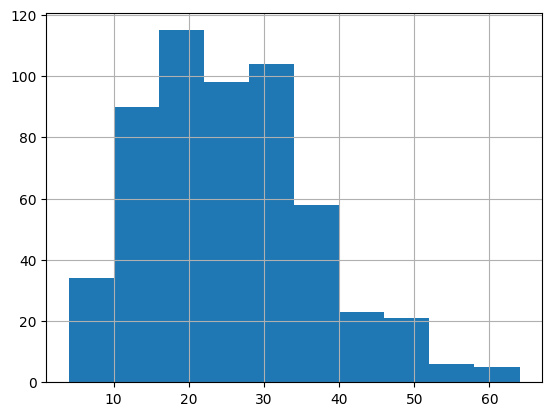

In [8]:
df[VITAMINE_D].hist()

# Model selection for vitamin D

In [9]:
df_vit_d_cleaned = df.dropna(subset=[VITAMINE_D])

X_vit_d, y_vit_d = df_vit_d_cleaned.drop(columns=[VITAMINE_D]), df_vit_d_cleaned[VITAMINE_D]
X_train_vit_d, X_test_vit_d, y_train_vit_d, y_test_vit_d = train_test_split(X_vit_d, y_vit_d, test_size=0.2, random_state=42)

In [10]:
models = [
        # DecisionTreeRegressor(max_depth=7, random_state=42),
        Lasso(),
        # Ridge(),
        RandomForestRegressor(),
        ]

continuous_preprocessings = {
    # 'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    # 'PT_KNN_7': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=7))]),
    'PT_KNN_9': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
    # 'PT_KNN_10': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=10))]),
    # 'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    # 'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
}

categorical_preprocessings = {
    'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    # 'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    # 'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
}

scores_df = explore_all_variations_of_preprocessing(X_train_vit_d, y_train_vit_d, VITAMINE_D, models, continuous_preprocessings, categorical_preprocessings)
scores_df

1/12 Lasso() PT_KNN_7 original_ohe_no_imputing [ 0.03096606  0.08848344  0.07994111  0.10626828  0.15468122  0.03919519
  0.01160862  0.17445066  0.02924198  0.12477572  0.1345052   0.13119404
  0.07319376  0.16537963 -0.10643843] 0.08249643179083584
2/12 RandomForestRegressor() PT_KNN_7 original_ohe_no_imputing [-0.08390771  0.04351091  0.04876437  0.15110838  0.15801872 -0.00505112
 -0.05328577  0.18713809  0.07420149  0.12697607  0.19613636  0.13005476
  0.1180487   0.16359798 -0.10755871] 0.07651683568740143
3/12 Lasso() PT_KNN_7 original_ohe_+_impute_knn [ 0.03096606  0.08848344  0.07994111  0.10626828  0.15468122  0.03919519
  0.01160862  0.17445066  0.02924198  0.12477572  0.1345052   0.13119404
  0.07319376  0.16537963 -0.10643843] 0.08249643179083584
4/12 RandomForestRegressor() PT_KNN_7 original_ohe_+_impute_knn [-0.0421505   0.05703483  0.03038859  0.14395116  0.1631126  -0.00396986
 -0.08587541  0.13765438  0.06453558  0.08000079  0.19165846  0.13023263
  0.12284299  0.1087

,continuous_preprocessing,categorical_pteprocessing,model,MAE
0,PT_KNN_7,original_ohe_no_imputing,Lasso(),0.082496
1,PT_KNN_7,original_ohe_no_imputing,RandomForestRegressor(),0.076517
2,PT_KNN_7,original_ohe_+_impute_knn,Lasso(),0.082496
3,PT_KNN_7,original_ohe_+_impute_knn,RandomForestRegressor(),0.065078
4,PT_KNN_9,original_ohe_no_imputing,Lasso(),0.082371
5,PT_KNN_9,original_ohe_no_imputing,RandomForestRegressor(),0.086732
6,PT_KNN_9,original_ohe_+_impute_knn,Lasso(),0.082371
7,PT_KNN_9,original_ohe_+_impute_knn,RandomForestRegressor(),0.077690
8,PT_KNN_10,original_ohe_no_imputing,Lasso(),0.082425
9,PT_KNN_10,original_ohe_no_imputing,RandomForestRegressor(),0.075085


In [21]:
scores_df.groupby(by=['model'])['MAE'].mean()

model
Lasso()                    8.976081
RandomForestRegressor()    8.930126
Name: MAE, dtype: float64

In [22]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    8.883338
                          original_ohe_+_impute_rf     8.899515
                          original_ohe_no_imputing     8.844582
PT_iterative_basic        original_ohe_+_impute_knn    8.901165
                          original_ohe_+_impute_rf     8.914229
                          original_ohe_no_imputing     8.925448
RS_KNN                    original_ohe_+_impute_knn    9.007031
                          original_ohe_+_impute_rf     9.005657
                          original_ohe_no_imputing     8.990216
RS_iterative_basic        original_ohe_+_impute_knn    9.004354
                          original_ohe_+_impute_rf     9.024740
                          original_ohe_no_imputing     9.036970
Name: MAE, dtype: float64

In [11]:
scores_df.groupby(by=['model'])['MAE'].mean()

model
DecisionTreeRegressor(max_depth=7, random_state=42)    11.816821
Lasso()                                                 9.060178
RandomForestRegressor()                                 9.037357
Ridge()                                                11.497512
Name: MAE, dtype: float64

In [7]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    10.206016
                          original_ohe_+_impute_rf     10.142260
                          original_ohe_no_imputing     10.221180
PT_iterative_basic        original_ohe_+_impute_knn    10.169115
                          original_ohe_+_impute_rf     10.208578
                          original_ohe_no_imputing     10.249406
RS_KNN                    original_ohe_+_impute_knn    10.495360
                          original_ohe_+_impute_rf     10.508968
                          original_ohe_no_imputing     10.596368
RS_iterative_basic        original_ohe_+_impute_knn    10.476707
                          original_ohe_+_impute_rf     10.430341
                          original_ohe_no_imputing     10.531306
Name: MAE, dtype: float64

In [8]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    10.106080
                          original_ohe_+_impute_rf     10.134701
                          original_ohe_no_imputing     10.057171
PT_iterative_basic        original_ohe_+_impute_knn    10.101045
                          original_ohe_+_impute_rf     10.086042
                          original_ohe_no_imputing     10.052659
RS_KNN                    original_ohe_+_impute_knn    10.118658
                          original_ohe_+_impute_rf     10.109679
                          original_ohe_no_imputing     10.055548
RS_iterative_basic        original_ohe_+_impute_knn    10.121895
                          original_ohe_+_impute_rf     10.170401
                          original_ohe_no_imputing     10.066486
Name: MAE, dtype: float64

In [9]:
scores_df.groupby(by=['continuous_preprocessing'])['MAE'].mean()

continuous_preprocessing
PT_KNN                10.099317
PT_iterative_basic    10.079915
RS_KNN                10.094628
RS_iterative_basic    10.119594
Name: MAE, dtype: float64

In [10]:
scores_df.groupby(by=['categorical_pteprocessing'])['MAE'].mean()

categorical_pteprocessing
original_ohe_+_impute_knn    10.111920
original_ohe_+_impute_rf     10.125206
original_ohe_no_imputing     10.057966
Name: MAE, dtype: float64

In [11]:
scores_df.groupby(by=['model'])['MAE'].mean()

model
DecisionTreeRegressor(max_depth=7, random_state=42)    11.364120
Lasso()                                                 8.830515
RandomForestRegressor()                                 8.975628
Ridge()                                                11.223191
Name: MAE, dtype: float64

Best preprocessing techniques for vitamine D:
- PT_KNN  + original_ohe_no_imputing

In [11]:
continuous_preprocessor = Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))])
categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

### Hyperparameter tuning

### Lasso

Fitting 15 folds for each of 6 candidates, totalling 90 fits


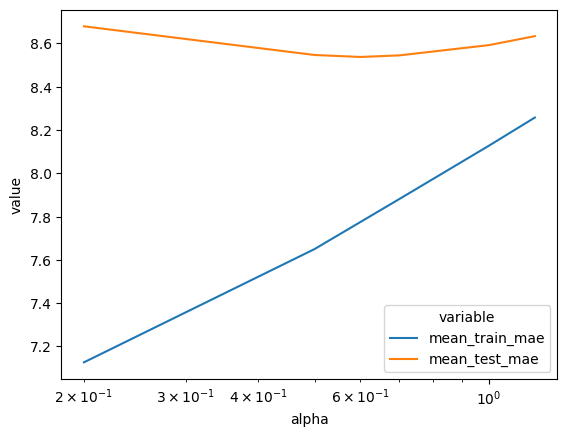

,alpha,mean_train_mae,mean_test_mae
0,0.2,7.126772,8.678879
1,0.5,7.649897,8.546469
2,0.6,7.774955,8.537318
3,0.7,7.880766,8.544606
4,1,8.127568,8.592027
5,1.2,8.257494,8.633588


In [12]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.2, 0.5, 0.6, 0.7, 1, 1.2],
    }

vit_d_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Lasso(), continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
vit_d_lasso_model_hyperparam_tuning_df

### Ridge

Fitting 15 folds for each of 8 candidates, totalling 120 fits


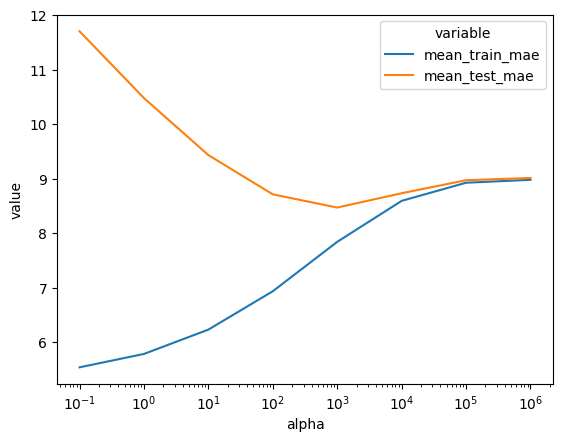

,alpha,mean_train_mae,mean_test_mae
0,0.1,5.542034,11.701898
1,1,5.787469,10.477764
2,10,6.233465,9.432432
3,100,6.936897,8.713139
4,1000,7.842534,8.470995
5,10000,8.593776,8.733534
6,100000,8.926022,8.972071
7,1000000,8.979400,9.013625


In [43]:
ridge_param_grid = {
    "model__alpha": [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Ridge(), continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

### DecisionTreeRegressor

In [35]:
tree_model = DecisionTreeRegressor()

tree_param_grid = {
    "model__criterion": ["absolute_error"],
    "model__max_depth": [8, 9, 10, 12],
    "model__splitter": ["random", "best"],
    "model__min_samples_split": [15, 16, 17, 20],
    "model__min_samples_leaf": [20, 22, 25, 27],
    }

vit_d_tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, tree_model, continuous_preprocessor, categorical_preprocessor, tree_param_grid)
vit_d_tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 128 candidates, totalling 1920 fits


,params,mean_train_mae,mean_test_mae
94,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 20, 'model__splitter': 'random'}",8.051596,9.153658
114,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 25, 'model__min_samples_split': 16, 'model__splitter': 'random'}",7.931328,9.171357
22,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 25, 'model__min_samples_split': 20, 'model__splitter': 'random'}",7.933408,9.227749
16,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}",7.942298,9.232884
42,"{'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 22, 'model__min_samples_split': 16, 'model__splitter': 'random'}",7.891790,9.258377
18,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 25, 'model__min_samples_split': 16, 'model__splitter': 'random'}",8.009245,9.266767
28,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17, 'model__splitter': 'random'}",8.021903,9.289721
122,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 16, 'model__splitter': 'random'}",8.007836,9.298851
92,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17, 'model__splitter': 'random'}",8.023786,9.300637
112,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}",8.011512,9.333725


In [11]:
model = DecisionTreeRegressor(criterion="absolute_error", max_depth=10, min_samples_leaf=27, min_samples_split=15, splitter='random')

tuned_df = compare_random_states(X_train_vit_d, y_train_vit_d, model, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [01:35<00:00,  1.03it/s]


,cv_mae
62,-9.07908
58,-9.187412
14,-9.191769
51,-9.192326
83,-9.193849


### Random Forest

In [42]:
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [3, 5, 7],
    'model__min_samples_leaf': [3, 5, 7],
}

vit_d_rf_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, RandomForestRegressor(criterion="absolute_error"), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
vit_d_rf_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 18 candidates, totalling 270 fits


,params,mean_train_mae,mean_test_mae
8,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}",6.047948,8.726923
15,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 200}",6.544893,8.740124
1,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'model__n_estimators': 200}",5.119564,8.741829
17,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 7, 'model__n_estimators': 200}",6.547260,8.743113
16,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 7, 'model__n_estimators': 100}",6.558310,8.747370
7,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 3, 'model__n_estimators': 200}",6.049708,8.749739
14,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 100}",6.570497,8.753219
13,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 200}",6.547810,8.758884
9,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}",6.038521,8.759326
10,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 7, 'model__n_estimators': 100}",6.066576,8.763497


In [43]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, max_features='sqrt', min_samples_leaf=5, min_samples_split=5, criterion='absolute_error')

tuned_df = compare_random_states(X_train_vit_d, y_train_vit_d, model, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [09:45<00:00,  5.92s/it]


,cv_mae
13,-8.697161
16,-8.713622
7,-8.714204
61,-8.714876
72,-8.717986


## Best models for Vitamine D

In [40]:
def get_feature_importance_lasso(pipeline: Pipeline, target_attribute, significance_threshold=0.1):
    lasso_coefs = pipeline['model'].coef_
    column_names = pipeline['preprocessor'].get_feature_names_out()

    feature_importnces_lasso = [*zip(column_names, lasso_coefs)]
    feature_importances = pd.DataFrame(feature_importnces_lasso, columns=['feature', 'importance'])
    feature_importances_sorted = feature_importances[feature_importances['importance'].abs() > significance_threshold].sort_values(by='importance', key=abs, ascending=False)

    sns.barplot(feature_importances_sorted.head(20), x="importance", y="feature").set(title=target_attribute)
    plt.show()

    return feature_importances_sorted


def get_feature_importance_tree(pipeline: Pipeline, target_attribute, significance_threshold=0):
    feature_importances = pipeline['model'].feature_importances_
    column_names = pipeline['preprocessor'].get_feature_names_out()

    feature_importnces_with_columns = [*zip(column_names, feature_importances)]
    feature_importances_df = pd.DataFrame(feature_importnces_with_columns, columns=['feature', 'importance'])
    feature_importances_sorted = feature_importances_df[feature_importances_df['importance'].abs() > significance_threshold].sort_values(by='importance', key=abs, ascending=False)

    sns.barplot(feature_importances_sorted, x="importance", y="feature").set(title=target_attribute)
    plt.show()

    plot_tree(pipeline['model'], feature_names=column_names)
    plt.savefig(f'charts/decision_tree_.pdf')
    plt.show()

    return feature_importances_sorted

def get_feature_importance_rf(pipeline: Pipeline, target_attribute, significance_threshold=0.01):
    feature_importances = pipeline['model'].feature_importances_
    column_names = pipeline['preprocessor'].get_feature_names_out()

    feature_importnces_with_columns = [*zip(column_names, feature_importances)]
    feature_importances_df = pd.DataFrame(feature_importnces_with_columns, columns=['feature', 'importance'])
    feature_importances_sorted = feature_importances_df[feature_importances_df['importance'].abs() > significance_threshold].sort_values(by='importance', key=abs, ascending=False)

    sns.barplot(feature_importances_sorted, x="importance", y="feature").set(title=target_attribute)
    plt.show()

    return feature_importances_sorted


def show_plots(y_true, y_pred, dataset_label):
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=axs[0],
        random_state=42,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        ax=axs[1],
        random_state=42,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle(f"Predictions on a {dataset_label} set")
    plt.tight_layout()
    plt.show()


def get_regression_metrics(y_true, y_pred):
    mse = round(mean_squared_error(y_true, y_pred), 3)
    mae = round(mean_absolute_error(y_true, y_pred), 3)
    rmse = round(root_mean_squared_error(y_true, y_pred), 3)
    r2 = round(r2_score(y_true, y_pred), 3)

    return mse, mae, rmse, r2


def train_model(model, target_attribute, X_train, y_train, X_test, y_test, continuous_preprocessor, categorical_preprocessor, feature_importance_method):
    model_scores_df = pd.DataFrame(columns=['model', 'data_set', 'mse', "mae", "rmse", 'r2'])
    preprocessor = ColumnTransformer(
        verbose_feature_names_out=False,
        transformers=[
            ('num', continuous_preprocessor, get_continuous_attributes_except(target_attribute)),
            ('cat', categorical_preprocessor, CATEGORICAL_ATTRIBUTES)
        ])
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])

    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    train_mse, train_mae, train_rmse, train_r2 = get_regression_metrics(y_train, y_pred_train)
    test_mse, test_mae, test_rmse, test_r2 = get_regression_metrics(y_test, y_pred_test)

    show_plots(y_train, y_pred_train, 'training')
    show_plots(y_test, y_pred_test, 'test')

    model_scores_df.loc[len(model_scores_df)] = [str(model), 'training', train_mse, train_mae, train_rmse, train_r2]
    model_scores_df.loc[len(model_scores_df)] = [str(model), 'test', test_mse, test_mae, test_rmse, test_r2]

    feature_importnces = feature_importance_method(pipeline, target_attribute)
    
    return model_scores_df, feature_importnces

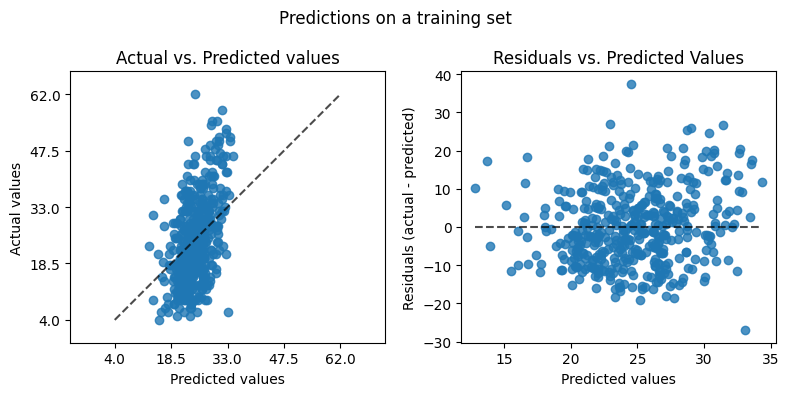

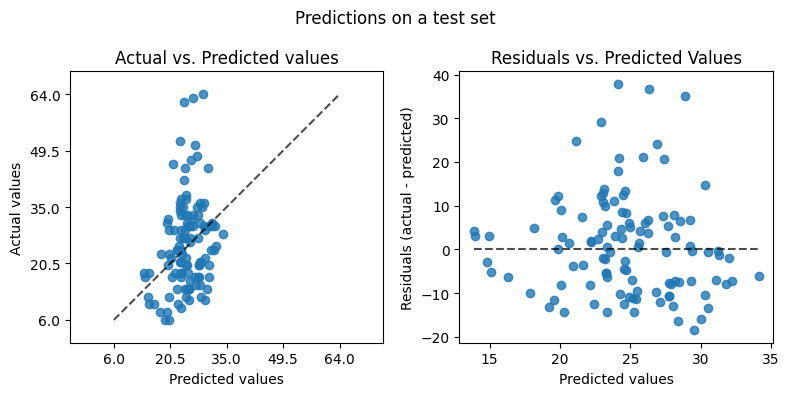

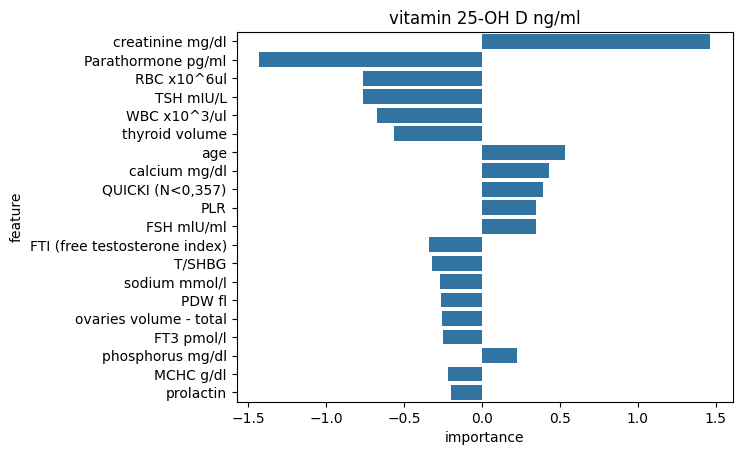

,model,data_set,mse,mae,rmse,r2
0,Lasso(alpha=0.6),training,96.058,7.916,9.801,0.220
1,Lasso(alpha=0.6),test,133.875,8.923,11.570,0.052


In [16]:
lasso_model = Lasso(alpha=0.6)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

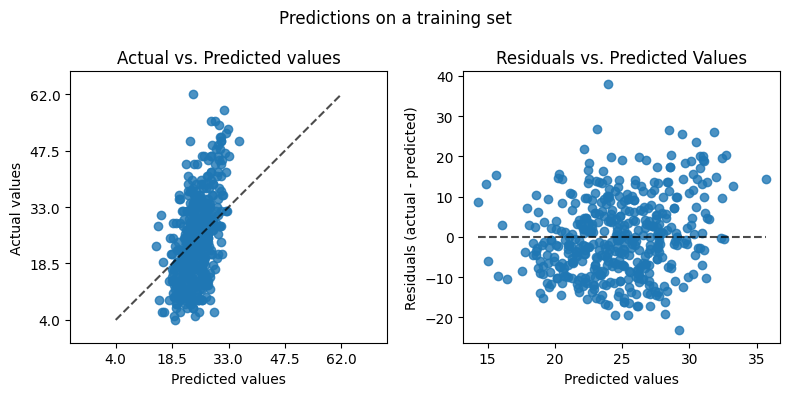

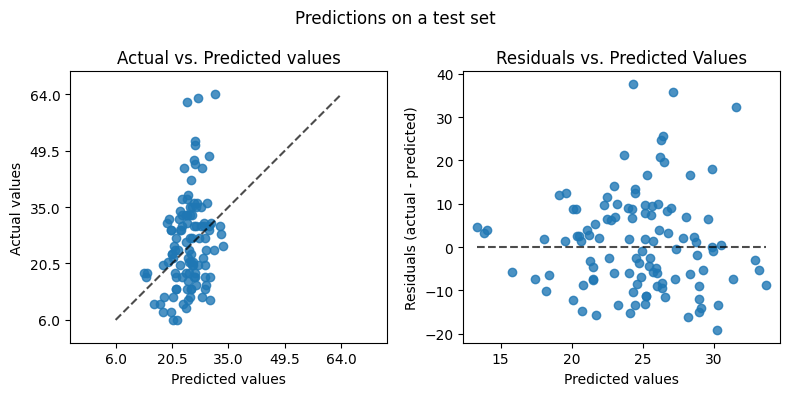

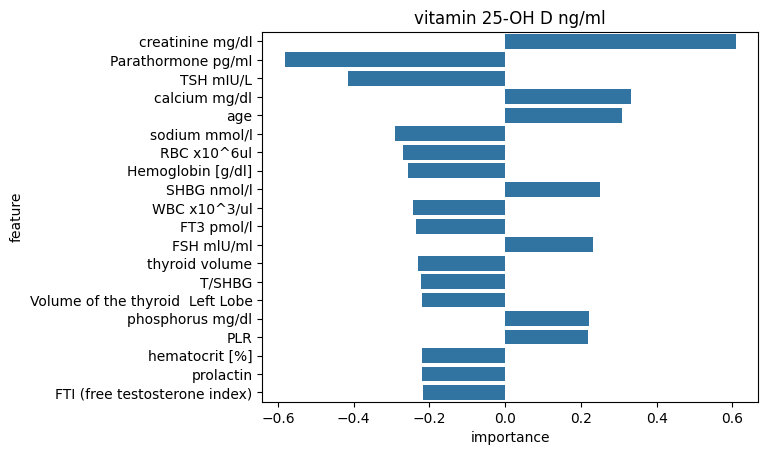

,model,data_set,mse,mae,rmse,r2
0,Ridge(alpha=1000),training,94.878,7.867,9.741,0.229
1,Ridge(alpha=1000),test,128.543,8.936,11.338,0.090


In [18]:
ridge_model = Ridge(alpha=1000)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

In [19]:
feature_importnces_ridge

,feature,importance
54,creatinine mg/dl,0.608745
100,Parathormone pg/ml,-0.582277
86,TSH mIU/L,-0.414065
52,calcium mg/dl,0.331196
113,age,0.308718
50,sodium mmol/l,-0.291219
30,RBC x10^6ul,-0.270366
31,Hemoglobin [g/dl],-0.256168
104,SHBG nmol/l,0.249457
19,WBC x10^3/ul,-0.242142


### Decision Tree

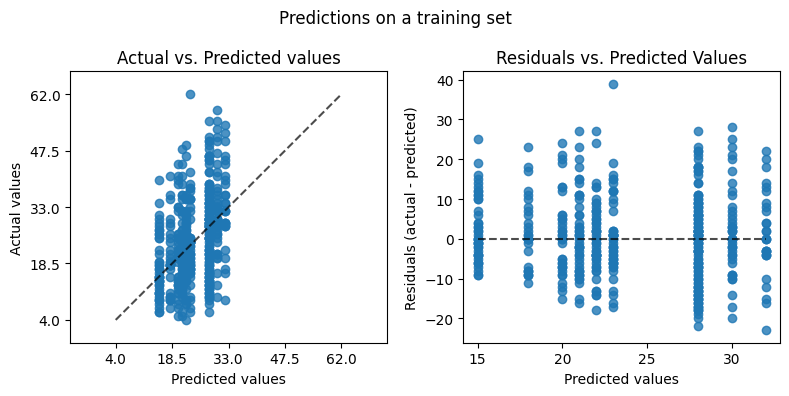

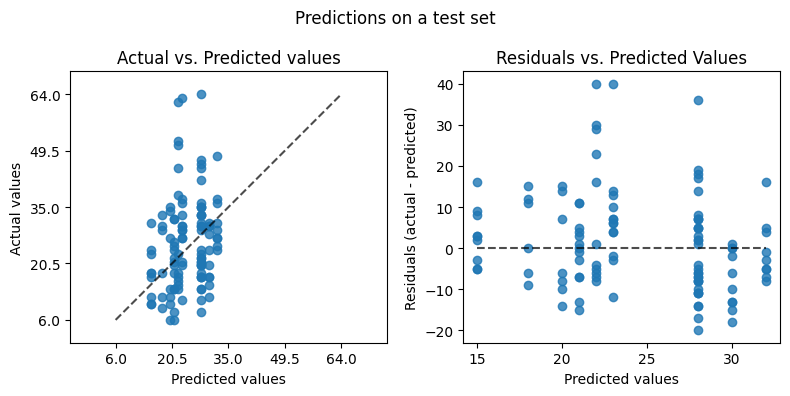

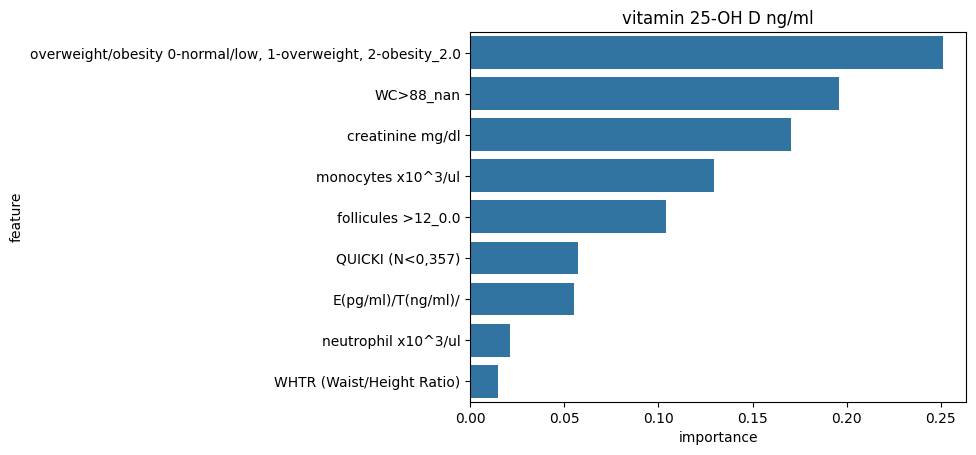

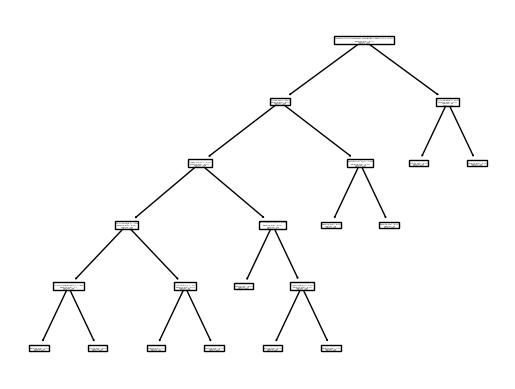

,model,data_set,mse,mae,rmse,r2
0,"DecisionTreeRegressor(criterion='absolute_error', max_depth=10,\n min_samples_leaf=27, min_samples_split=15,\n random_state=62, splitter='random')",training,104.801,7.894,10.237,0.149
1,"DecisionTreeRegressor(criterion='absolute_error', max_depth=10,\n min_samples_leaf=27, min_samples_split=15,\n random_state=62, splitter='random')",test,141.495,9.135,11.895,-0.002


In [22]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", max_depth=10, min_samples_leaf=27, min_samples_split=15, splitter='random', random_state=62)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

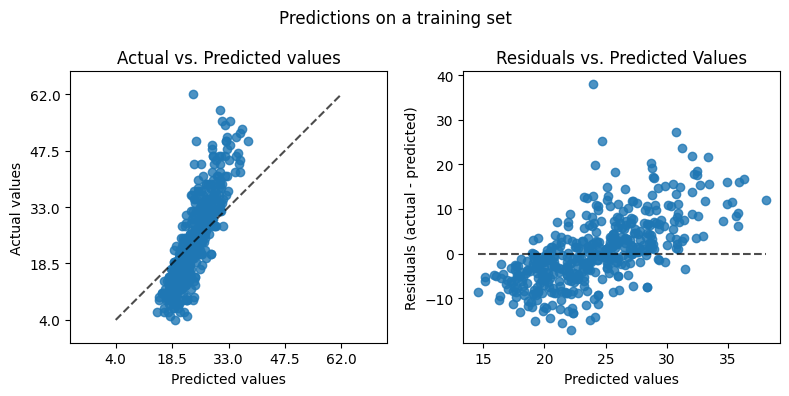

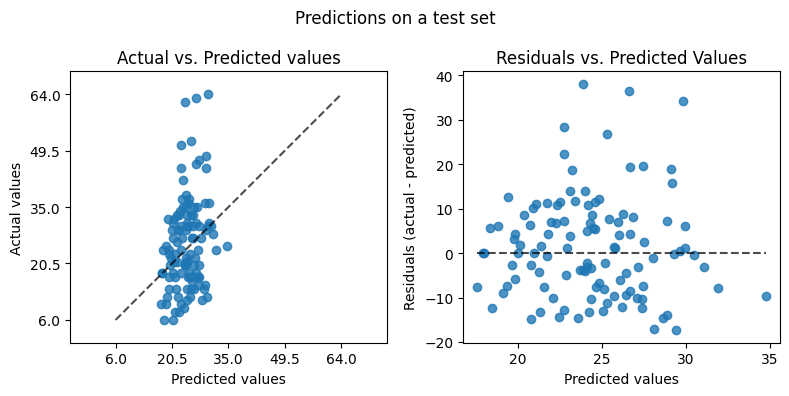

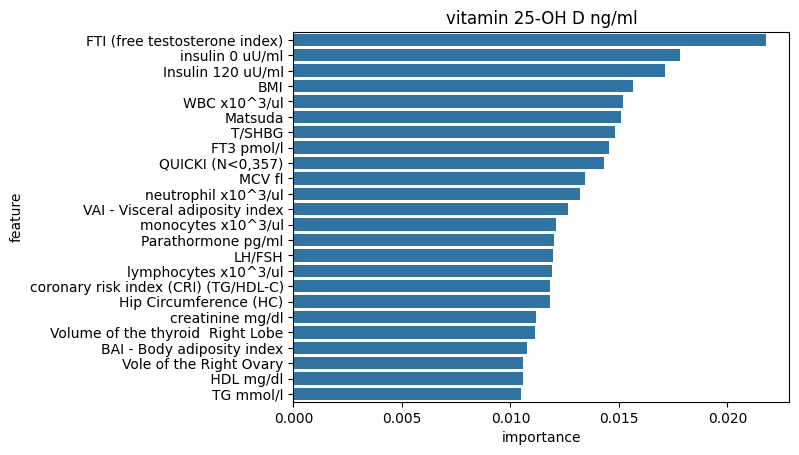

,model,data_set,mse,mae,rmse,r2
0,"RandomForestRegressor(criterion='absolute_error', max_depth=10,\n max_features='sqrt', min_samples_leaf=5,\n min_samples_split=5, n_estimators=200, random_state=13)",training,59.754,5.884,7.730,0.515
1,"RandomForestRegressor(criterion='absolute_error', max_depth=10,\n max_features='sqrt', min_samples_leaf=5,\n min_samples_split=5, n_estimators=200, random_state=13)",test,133.318,8.968,11.546,0.056


In [42]:
feature_importnces_rf

,feature,importance
105,FTI (free testosterone index),0.021771
81,insulin 0 uU/ml,0.017820
82,Insulin 120 uU/ml,0.017107
5,BMI,0.015667
19,WBC x10^3/ul,0.015205
84,Matsuda,0.015095
98,T/SHBG,0.014819
87,FT3 pmol/l,0.014530
85,"QUICKI (N<0,357)",0.014337
34,MCV fl,0.013433


In [ ]:
# TODO: zrobić jakieś podsumowanie feature importance ze wszystkich klasyfikatorów  + użyć innych metod na feature selection

Most important attributes for `vitamin D`: 'creatinine mg/dl', 'Parathormone pg/ml', 'FTI (free testosterone index)'